### Description
This script computes Jaccard similarity scores for pairs of movies based on the column 'Genre Name,' creates a matrix of similarity scores, performs spectral embedding, and then performs clustering on the transformed space. It also outputs plots for determining the optimal parameters for spectral embedding and clustering. Using the clusters from k-means, we can group our genres into broader "umbrella" genres for better encoding.

In [78]:
import pandas as pd
from sklearn.metrics import jaccard_score
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csgraph
import ast

# Load csv
df = pd.read_csv('../merged_data_mod_scores_filtered_US_release_year_star_scores_prod_scores_dir_scores.csv')

In [45]:
# Create Jaccard Similarity Matrix

# Initialize Similarity Matrix
num_movies = len(df)
jaccard_similarity_matrix = np.zeros((num_movies, num_movies))

# Compute Similarity Matrix
for i in range(num_movies):
    
    # Progress Tracker
    print(f'Processing movie {i + 1} out of {num_movies}')
    
    # Set of Genres for Movie i
    genres_i = set(df.iloc[i]['Genre Name'].split(','))
    
    # Calculate Jaccard Similarity for (i,j) Pairs of Movies
    ## Starts at i Since 1,...,i-1 already calculated by last line of loop
    for j in range(i, num_movies):
        # Similarity Score for Movie i with Itself
        if j==i:
            jaccard_similarity_matrix[j, i] = 1
        else:
            # Set of Genres for Movie j
            genres_j = set(df.iloc[j]['Genre Name'].split(','))

            intersection_size = len(genres_i.intersection(genres_j))
            union_size = len(genres_i.union(genres_j))

            # Similarity Score
            jaccard_similarity_matrix[i, j] = intersection_size / union_size
            jaccard_similarity_matrix[j, i] = jaccard_similarity_matrix[i, j]
                # Since Jaccard Similarity Matrix is Symmetric, ij=ji

Processing movie 1 out of 3595
Processing movie 2 out of 3595
Processing movie 3 out of 3595
Processing movie 4 out of 3595
Processing movie 5 out of 3595
Processing movie 6 out of 3595
Processing movie 7 out of 3595
Processing movie 8 out of 3595
Processing movie 9 out of 3595
Processing movie 10 out of 3595
Processing movie 11 out of 3595
Processing movie 12 out of 3595
Processing movie 13 out of 3595
Processing movie 14 out of 3595
Processing movie 15 out of 3595
Processing movie 16 out of 3595
Processing movie 17 out of 3595
Processing movie 18 out of 3595
Processing movie 19 out of 3595
Processing movie 20 out of 3595
Processing movie 21 out of 3595
Processing movie 22 out of 3595
Processing movie 23 out of 3595
Processing movie 24 out of 3595
Processing movie 25 out of 3595
Processing movie 26 out of 3595
Processing movie 27 out of 3595
Processing movie 28 out of 3595
Processing movie 29 out of 3595
Processing movie 30 out of 3595
Processing movie 31 out of 3595
Processing movie 

In [46]:
print(jaccard_similarity_matrix)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


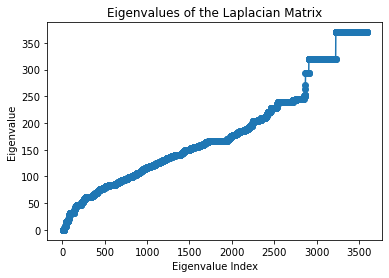

In [27]:
# Determine Optimal n for Spectral Embedding using Laplacian eigenvalues
laplacian_matrix = csgraph.laplacian(jaccard_similarity_matrix, normed=False)
laplacian_eigenvalues = np.linalg.eigvalsh(laplacian_matrix)

# Plot the eigenvalues
plt.plot(range(1, len(laplacian_eigenvalues) + 1), laplacian_eigenvalues, marker='o')
plt.title('Eigenvalues of the Laplacian Matrix')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.show()

The analysis here is largely unhelpful since more dimensions seem to always lead to more data. As such, we'll choose $n=3$ for simplicity's sake.

In [64]:
# Step 3: Perform spectral embedding
spectral_embedding = SpectralEmbedding(n_components=3)
embedded_matrix = spectral_embedding.fit_transform(jaccard_similarity_matrix)

/Users/Jeewon/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


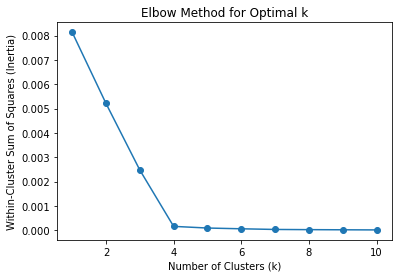

In [65]:
# Determine Optimal k
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedded_matrix)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.show()

It looks like our optimal $n$ is

In [66]:
# Step 4: Perform clustering using KMeans
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(embedded_matrix)
print(len(clusters))

3595


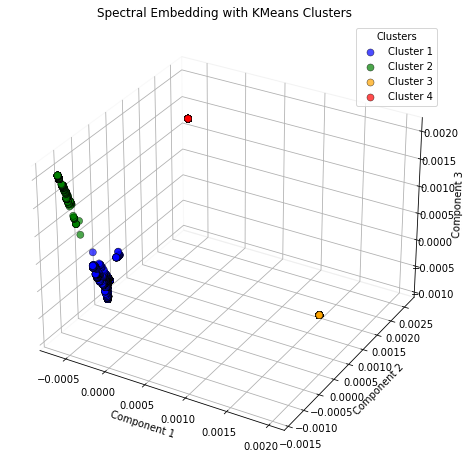

In [80]:
# Plot the embedded matrix and clusters in 3D space with enhanced styling
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each cluster
colors = ['blue', 'green', 'orange', 'red']

# Scatter plot for each point in the embedded matrix, colored by cluster
for cluster_id, color in zip(range(4), colors):
    cluster_indices = np.where(clusters == cluster_id)
    ax.scatter(embedded_matrix[cluster_indices, 0], 
               embedded_matrix[cluster_indices, 1], 
               embedded_matrix[cluster_indices, 2],
               label=f'Cluster {cluster_id + 1}', 
               marker='o',
               color=color,
               s=50,  # Adjust marker size
               alpha=0.7,  # Adjust transparency
               edgecolors='k',  # Add black edges to markers
               linewidths=0.5  # Adjust edge linewidth
              )

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('Spectral Embedding with KMeans Clusters')

# Add legend with a title
ax.legend(title='Clusters', loc='upper right')

# Customize grid lines
ax.grid(True, linestyle='--', alpha=0.5)

# Customize ticks
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.set_tick_params(width=0.5)
ax.yaxis.set_tick_params(width=0.5)
ax.zaxis.set_tick_params(width=0.5)

plt.show()

In [79]:
df['Genre Cluster'] = clusters

# Convert the string representation of lists to actual lists
df['Genre Name'] = df['Genre Name'].apply(ast.literal_eval)
    
# Extract the set of lists of genres for each cluster
cluster_genres = df.groupby('Genre Cluster')['Genre Name'].apply(lambda x: set(tuple(genres) for genres in x)).to_dict()

# Print the set of lists of genres in each cluster
for cluster_id, genres in cluster_genres.items():
    print(f'Genre Cluster {cluster_id + 1}: {genres}')

Genre Cluster 1: {('Documentary', 'Music', 'Comedy'), ('Adventure', 'Science Fiction', 'Action', 'Comedy'), ('Comedy', 'Action', 'Crime'), ('Romance', 'Music', 'Drama', 'Thriller'), ('Adventure', 'Comedy', 'Family'), ('Action', 'Comedy', 'Crime', 'Drama', 'Thriller'), ('Science Fiction', 'Fantasy', 'Action'), ('Horror', 'Documentary'), ('Action', 'Adventure', 'Crime'), ('Western',), ('Documentary', 'Adventure'), ('Adventure', 'Family', 'Fantasy', 'Romance'), ('Action', 'Animation', 'Comedy', 'Family', 'Adventure'), ('Crime', 'Drama', 'Mystery', 'Thriller'), ('Crime', 'Drama', 'Action'), ('Mystery', 'Thriller', 'Action'), ('Thriller', 'Science Fiction', 'Horror'), ('Action', 'Mystery', 'Thriller', 'Crime'), ('Animation', 'Family', 'Fantasy', 'Comedy', 'Adventure', 'Mystery'), ('Action', 'Adventure', 'Horror'), ('Thriller', 'Crime', 'Drama'), ('Science Fiction', 'Adventure', 'Thriller'), ('Science Fiction', 'Comedy', 'Drama', 'Romance'), ('Thriller', 'Action', 'Comedy'), ('Western', 'Cri

In [81]:
# Assuming df is your DataFrame
df.to_csv('merged_US_allscores_similarity.csv', index=False)